# Set Environement and Import Library & Data

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# import libraries
import pickle
import time
from math import ceil

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import xgboost as xgb

from matplotlib.figure import Figure
from numpy import linspace, logspace, ndarray
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import ElasticNet, Ridge, Lasso, LinearRegression
from sklearn.metrics import confusion_matrix, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVR, SVR
from tqdm.notebook import tqdm
from typing import Union

from helper import create_quali_df, create_quanti_df

In [4]:
# import and backup dataset
path = "data/clean_df_engineering.csv"
df = pd.read_csv(path)
df_copy = df.copy()
df.shape

(6697, 27)

# Fonctions d'Outils

In [5]:
def split_train_test(df: pd.DataFrame) -> pd.DataFrame:
    # get common OSEBuildingIDs from both 2015 and 2016 dataframes
    build_id = set(df[df.DataYear == 2015].OSEBuildingID).intersection(
        set(df[df.DataYear == 2016].OSEBuildingID)
    )

    # seperate dataframe according to OSEBuildingID (common or unique in 2015 & 2016 dataset)
    # that will be used as train and test sets respectively
    df_common_id = df[df.OSEBuildingID.isin(build_id)].drop(columns=['OSEBuildingID', 'DataYear'])
    df_unique_id = df[~df.OSEBuildingID.isin(build_id)].drop(columns=['OSEBuildingID', 'DataYear'])

    return df_common_id, df_unique_id


def prepare_df(df: pd.DataFrame, cols_to_drop:list) -> pd.DataFrame:
    # remove rows where  contains null values
    df = df[df.ENERGYSTARScore.notnull()]
    
    df = df.drop(columns=cols_to_drop)
    return df


def plot_double_metrics(
    df: pd.DataFrame,
    x: str,
    left: str,
    right: str,
    title: str,
    fontsize: int = 13,
    rotation: int = 0,
) -> plt.plot:
    """
    plot metrics for comparison

    Parameters
    ----------
    df: dataframe
        The dataframe to be plotted
    x: string
        The name of the variable to be plotted on the x-axis
    left, right: string
        Metrics to be plotted on left and right y-axis
    title: string
        The title of the graph
    fontsize: int
        Set fontsize of the ticks on the x-axis
    rotation: int
        Set rotation angle of the ticks on the x-axis

    Returns
    -------
    plotted data
        A graph with 2 metrics on the same graph

    """

    # plot metric for y-axis on the left
    fig, ax1 = plt.subplots()
    color = "tab:blue"
    ax1.plot(x, left, data=df, color=color)
    plt.title(title)
    ax1.set_xlabel(x)
    ax1.tick_params(axis="x", labelsize=fontsize, labelrotation=rotation)
    ax1.set_ylabel(left, color=color)
    ax1.tick_params(axis="y", labelcolor=color)

    # plot metric for y-axis on the right
    ax2 = ax1.twinx()
    color = "tab:red"
    ax2.plot(x, right, data=df, color=color)
    ax2.set_ylabel(right, color=color)
    ax2.tick_params(axis="y", labelcolor=color)

    # show graph
    fig.tight_layout()
    plt.show()
    return


def plot_single_metrics(
    df: pd.DataFrame,
    x: str,
    metric: str,
    title: str,
    fontsize: int = 13,
    rotation: int = 0,
) -> plt.plot:
    """
    plot metric

    Parameters
    ----------
    df: dataframe
        The dataframe to be plotted
    x: string
        The name of the variable to be plotted on the x-axis
    metric: string
        The name of the metric to be plotted
    title: string
        The title of the graph
    fontsize: int
        Set fontsize of the ticks on the x-axis
    rotation: int
        Set rotation angle of the ticks on the x-axis

    Returns
    -------
    plotted data
        A graph of the metric

    """

    # plot "Duration" for comparison
    plt.plot(x, metric, data=df)
    plt.title(title)
    plt.xlabel(x)
    plt.tick_params(axis="x", labelsize=fontsize, labelrotation=rotation)
    plt.ylabel(metric)
    plt.show()

    return

# Préprocessing

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6697 entries, 0 to 6696
Data columns (total 27 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   OSEBuildingID                     6697 non-null   int64  
 1   DataYear                          6697 non-null   int64  
 2   BuildingType                      6697 non-null   object 
 3   PropertyName                      6697 non-null   object 
 4   TaxParcelIdentificationNumber     6695 non-null   object 
 5   CouncilDistrictCode               6697 non-null   int64  
 6   Neighborhood                      6697 non-null   object 
 7   YearBuilt                         6697 non-null   int64  
 8   NumberofBuildings                 6697 non-null   float64
 9   NumberofFloors                    6689 non-null   float64
 10  PropertyGFATotal                  6697 non-null   int64  
 11  PropertyGFAParking                6697 non-null   int64  
 12  ENERGY

In [7]:
# check null values
df.isnull().sum()

OSEBuildingID                          0
DataYear                               0
BuildingType                           0
PropertyName                           0
TaxParcelIdentificationNumber          2
CouncilDistrictCode                    0
Neighborhood                           0
YearBuilt                              0
NumberofBuildings                      0
NumberofFloors                         8
PropertyGFATotal                       0
PropertyGFAParking                     0
ENERGYSTARScore                     1604
SiteEnergyUse(kBtu)                    0
GHGEmissions(MetricTonsCO2e)           0
DefaultData                            0
ComplianceStatus                       0
Address                                0
Distance                               0
PropertyGFATotal_log                   0
PropertyGFAParking_log                 0
SiteEnergyUse(kBtu)_log                0
GHGEmissions(MetricTonsCO2e)_log       0
FirstLargestPropertyUseType            0
SecondLargestPro

## Variables Quantitatives

### Valeurs Nulles

In [8]:
# df = df_copy.copy()

In [9]:
# create a df that containes only qualitative features
df_quanti = create_quanti_df(df)
df_quanti.shape

(6697, 16)

In [10]:
# check null values for quantitatives variables
df_quanti.isnull().sum()

OSEBuildingID                          0
DataYear                               0
CouncilDistrictCode                    0
YearBuilt                              0
NumberofBuildings                      0
NumberofFloors                         8
PropertyGFATotal                       0
PropertyGFAParking                     0
ENERGYSTARScore                     1604
SiteEnergyUse(kBtu)                    0
GHGEmissions(MetricTonsCO2e)           0
Distance                               0
PropertyGFATotal_log                   0
PropertyGFAParking_log                 0
SiteEnergyUse(kBtu)_log                0
GHGEmissions(MetricTonsCO2e)_log       0
dtype: int64

#### 'NumberofFloors'

In [11]:
# check all the null entries in "NumberofFloors"
df_num_fls_null = df[["OSEBuildingID", "DataYear", "NumberofFloors"]][
    df.NumberofFloors.isnull()
]
df_num_fls_null

,OSEBuildingID,DataYear,NumberofFloors
2008,24086,2015,NaN
3161,40028,2015,NaN
3162,40031,2015,NaN
3163,40034,2015,NaN
3183,43948,2015,NaN
3199,49705,2015,NaN
3301,49958,2015,NaN
3303,49966,2015,NaN


**Remarque:**
Toutes les valeurs manquantes sont en 2015

In [12]:
# check the values of the same buildings in 2016
mask = df.OSEBuildingID.isin(df_num_fls_null.OSEBuildingID)
cols = ["OSEBuildingID", "DataYear", "NumberofFloors"]
df[mask][cols].sort_values(by="OSEBuildingID")

,OSEBuildingID,DataYear,NumberofFloors
2008,24086,2015,NaN
5318,24086,2016,0.0
3161,40028,2015,NaN
6452,40028,2016,0.0
3162,40031,2015,NaN
6453,40031,2016,0.0
3163,40034,2015,NaN
6454,40034,2016,0.0
3183,43948,2015,NaN
6474,43948,2016,2.0


**Remarque**

Nous allons remplir les valeurs manquantes en 2015 avec les valeurs en 2016.

In [13]:
# sort dataframe by columns 'OSEBuildingID' then 'DataYear'
df.sort_values(by=['OSEBuildingID', 'DataYear'], inplace=True)
df.head(6)

,OSEBuildingID,DataYear,BuildingType,PropertyName,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,...,Address,Distance,PropertyGFATotal_log,PropertyGFAParking_log,SiteEnergyUse(kBtu)_log,GHGEmissions(MetricTonsCO2e)_log,FirstLargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,BuiltAge
0,1,2015,NonResidential,MAYFLOWER PARK HOTEL,659000030,7,DOWNTOWN,1927,1.0,12.0,...,405 OLIVE WAY,7722.245502,11.390012,0.000000,15.758764,5.523179,Lodging/Residential,Inexistent,Inexistent,90-100
3330,1,2016,NonResidential,Mayflower park hotel,0659000030,7,DOWNTOWN,1927,1.0,12.0,...,405 Olive way,7722.245042,11.390012,0.000000,15.793246,5.525373,Lodging/Residential,Inexistent,Inexistent,90-100
1,2,2015,NonResidential,PARAMOUNT HOTEL,659000220,7,DOWNTOWN,1996,1.0,11.0,...,724 PINE ST,7722.394561,11.547964,9.620129,15.938279,5.577879,Lodging/Residential,Others,Restaurant/Bar,20-30
3331,2,2016,NonResidential,Paramount Hotel,0659000220,7,DOWNTOWN,1996,1.0,11.0,...,724 Pine street,7722.361218,11.547964,9.620129,15.942305,5.693261,Lodging/Residential,Others,Restaurant/Bar,20-30
2,3,2015,NonResidential,WESTIN HOTEL,659000475,7,DOWNTOWN,1969,1.0,41.0,...,1900 5TH AVE,7722.162218,13.776759,0.000000,18.107758,7.631664,Lodging/Residential,Others,Recreation,50-60
3332,3,2016,NonResidential,5673-The Westin Seattle,0659000475,7,DOWNTOWN,1969,1.0,41.0,...,1900 5th Avenue,7722.093624,13.770628,12.189532,18.100297,7.645053,Lodging/Residential,Inexistent,Inexistent,50-60


In [14]:
# fillna with the following values (fillna in 2015 by values in 2016)
df.NumberofFloors.fillna(method='bfill', inplace=True, limit=1)
# resort the df by its index
df.sort_index(inplace=True)
df_fillna_flrs = df.copy()
# check if there is still na in the column 'NumberofFloors'
df.NumberofFloors.isnull().sum()

0

In [15]:
# check if the values where correclty filled
df[mask][cols].sort_values(by="OSEBuildingID")

,OSEBuildingID,DataYear,NumberofFloors
2008,24086,2015,0.0
5318,24086,2016,0.0
3161,40028,2015,0.0
6452,40028,2016,0.0
3162,40031,2015,0.0
6453,40031,2016,0.0
3163,40034,2015,0.0
6454,40034,2016,0.0
3183,43948,2015,2.0
6474,43948,2016,2.0


In [16]:
# create a df that containes only qualitative features
df_quanti = create_quanti_df(df)
df_quanti.isnull().sum()

OSEBuildingID                          0
DataYear                               0
CouncilDistrictCode                    0
YearBuilt                              0
NumberofBuildings                      0
NumberofFloors                         0
PropertyGFATotal                       0
PropertyGFAParking                     0
ENERGYSTARScore                     1604
SiteEnergyUse(kBtu)                    0
GHGEmissions(MetricTonsCO2e)           0
Distance                               0
PropertyGFATotal_log                   0
PropertyGFAParking_log                 0
SiteEnergyUse(kBtu)_log                0
GHGEmissions(MetricTonsCO2e)_log       0
dtype: int64

#### 'ENERGYSTARScore'

In [17]:
# percentage of null values in "ENERGYSTARScore"
print(round(1604/len(df)*100, 2), "%")

23.95 %


**Remarqe** <br>
Nous allons le regarder plus tard avec les modèles entraînés pour décider s'il vaut la peine de le garder. Si on le garde, on décidera de la stratégie pour imputer les valeurs nulles à ce-moment là.

## Variables Qualitatives

### Sélection de Features

In [18]:
# df = df_fillna_flrs.copy()

In [19]:
# create a df that containes only qualitative features
df_quali = create_quali_df(df)
df_quali.shape

(6697, 10)

In [20]:
# check the number of unique values for qualitative variables
df_quali.nunique()

BuildingType                        8
PropertyName                     6514
TaxParcelIdentificationNumber    3722
Neighborhood                       13
ComplianceStatus                    4
Address                          6366
FirstLargestPropertyUseType        14
SecondLargestPropertyUseType       15
ThirdLargestPropertyUseType        15
BuiltAge                           13
dtype: int64

**Remarque**

Pour le modèle, les variables 'PropertyName' et 'TaxParcelIdentificationNumber' ne seront pas utiles et peuvent être supprimées.

Pareille pour 'Address', elle est redondante à la variable 'Distance' et peut être supprimée également.

In [21]:
# drop unnecessary columns
col_to_drop = [
    "PropertyName",
    "TaxParcelIdentificationNumber",
    "Address",
]
df.drop(col_to_drop, axis=1, inplace=True)
df_dense = df.copy()
df.shape

(6697, 24)

In [22]:
# re-create a df that containes only qualitative features
df_quali = create_quali_df(df)
df_quali.shape

(6697, 7)

In [23]:
# re-check the number of unique values for qualitative variables
df_quali.nunique()

BuildingType                     8
Neighborhood                    13
ComplianceStatus                 4
FirstLargestPropertyUseType     14
SecondLargestPropertyUseType    15
ThirdLargestPropertyUseType     15
BuiltAge                        13
dtype: int64

In [24]:
# check null values for qualitative variables
df_quali.isnull().sum()

BuildingType                    0
Neighborhood                    0
ComplianceStatus                0
FirstLargestPropertyUseType     0
SecondLargestPropertyUseType    0
ThirdLargestPropertyUseType     0
BuiltAge                        0
dtype: int64

**Remarque: **
Les variables qualitatives ne contiennent pas de valeurs nulles.

### Encoding

In [25]:
# df = df_dense.copy()

In [26]:
# check unique values for categorical variables
pd.Series({c: df[c].unique()for c in df_quali})

BuildingType                    [NonResidential, Nonresidential COS, Multifami...
Neighborhood                    [DOWNTOWN, SOUTHEAST, NORTHEAST, EAST, CENTRAL...
ComplianceStatus                [Compliant, Error - Correct Default Data, Miss...
FirstLargestPropertyUseType     [Lodging/Residential, Public Services, Enterta...
SecondLargestPropertyUseType    [Inexistent, Others, Restaurant/Bar, Office, L...
ThirdLargestPropertyUseType     [Inexistent, Restaurant/Bar, Recreation, Other...
BuiltAge                        [90-100, 20-30, 50-60, 40-50, 110-120, 10-20, ...
dtype: object

**Remarque**<br>
1. 'BuiltAge' est 'ordinal'
2. Les variables de *Property Use Type* ont des valeurs dupliquées parmi les 3 colonnes. Nous allons alors utiliser la technique 'Label Encoding'.
3. Pour le reste, nous allons encoder avec la technique 'One Hot Encoding'.

#### Ordinal Encoding

In [27]:
# create a dictionary to map the ordinal encoding
age_dict = {
    "<10": 1,
    "10-20" : 2,
    "20-30" : 3,
    "30-40" : 4,
    "40-50" : 5,
    "50-60" : 6,
    "60-70" : 7,
    "70-80" : 8,
    "80-90" : 9,
    "90-100" : 10,
    "100-110" : 11,
    "110-120" : 12,
    ">120" : 13,
}
# map the assigned numerical values to the original ordinal values
df['BuiltAge_Ordinal'] = df.BuiltAge.map(age_dict)
df.shape

(6697, 25)

In [28]:
# double check the mapped result
df[["BuiltAge", 'BuiltAge_Ordinal']].sample(10)

,BuiltAge,BuiltAge_Ordinal
925,50-60,6
2891,40-50,5
1128,30-40,4
3280,<10,1
4699,50-60,6
4726,30-40,4
3129,30-40,4
464,80-90,9
2926,60-70,7
5641,30-40,4


In [29]:
# drop the orginal ordinal column
df.drop(columns='BuiltAge', inplace=True)
df_ordinal = df.copy()

#### Label Encoding

In [30]:
# df = df_ordinal.copy()

In [31]:
# get all the unique values for the "Property Use Type"
usetype_list = list(df['FirstLargestPropertyUseType'].unique())
usetype_list.append('Inexistent')

In [32]:
# count all the unique values in all the "Property Use Type" columns
count1 = df.groupby("FirstLargestPropertyUseType")["FirstLargestPropertyUseType"].count()
count2 = df.groupby("SecondLargestPropertyUseType")["SecondLargestPropertyUseType"].count()
count3 = df.groupby("ThirdLargestPropertyUseType")["ThirdLargestPropertyUseType"].count()

In [33]:
# sum the counts of all the "Property Use Type" columns and rank
count1.add(count2, fill_value=0).add(count3, fill_value=0).sort_values(ascending=False)

Inexistent                       9013.0
Lodging/Residential              3620.0
Others                           2436.0
Office                           1889.0
Mall                              788.0
Warehouse                         749.0
Education                         376.0
Recreation                        291.0
Restaurant/Bar                    283.0
Entertainment/Public Assembly     257.0
Services                          162.0
Medical                            90.0
Technology/Science                 89.0
Utility                            27.0
Public Services                    21.0
dtype: float64

In [34]:
# create a dictionary to map the label encoding
usetype_labels = {
    "Inexistent": 1,
    "Lodging/Residential": 2,
    "Others": 3,
    "Office": 4,
    "Mall": 5,
    "Warehouse": 6,
    "Education": 7,
    "Recreation": 8,
    "Restaurant/Bar": 9,
    "Entertainment/Public Assembly": 10,
    "Services": 11,
    "Medical": 12,
    "Technology/Science": 13,
    "Utility": 14,
    "Public Services": 15,
}

# map the assigned numerical values to the original categorical values
df["FirstLargestPropertyUseType_Label"] = df["FirstLargestPropertyUseType"].map(
    usetype_labels
)
df["SecondLargestPropertyUseType_Label"] = df["SecondLargestPropertyUseType"].map(
    usetype_labels
)
df["ThirdLargestPropertyUseType_Label"] = df["ThirdLargestPropertyUseType"].map(
    usetype_labels
)
df.shape

(6697, 27)

In [35]:
# double check the mapped result
df[
    [
        "FirstLargestPropertyUseType",
        "FirstLargestPropertyUseType_Label",
        "SecondLargestPropertyUseType",
        "SecondLargestPropertyUseType_Label",
        "ThirdLargestPropertyUseType",
        "ThirdLargestPropertyUseType_Label",
    ]
].sample(10)

,FirstLargestPropertyUseType,FirstLargestPropertyUseType_Label,SecondLargestPropertyUseType,SecondLargestPropertyUseType_Label,ThirdLargestPropertyUseType,ThirdLargestPropertyUseType_Label
779,Others,3,Mall,5,Inexistent,1
4156,Lodging/Residential,2,Inexistent,1,Inexistent,1
5964,Lodging/Residential,2,Others,3,Inexistent,1
5461,Office,4,Others,3,Others,3
151,Education,7,Inexistent,1,Inexistent,1
4365,Lodging/Residential,2,Others,3,Inexistent,1
3114,Lodging/Residential,2,Inexistent,1,Inexistent,1
4068,Lodging/Residential,2,Inexistent,1,Inexistent,1
4291,Lodging/Residential,2,Restaurant/Bar,9,Inexistent,1
2052,Warehouse,6,Office,4,Inexistent,1


In [36]:
# drop the orginal categorical columns
df.drop(
    columns=[
        "FirstLargestPropertyUseType",
        "SecondLargestPropertyUseType",
        "ThirdLargestPropertyUseType",
    ],
    inplace=True,
)

# backup dataframe
df_label = df.copy()
df.shape

(6697, 24)

#### One Hot Encoding

In [37]:
# df = df_label.copy()

In [38]:
# create a df that containes only qualitative features
df_quali = create_quali_df(df)
df_quali.shape

(6697, 3)

In [39]:
# check the number of unique values for qualitative variables
df_quali.nunique()

BuildingType         8
Neighborhood        13
ComplianceStatus     4
dtype: int64

In [40]:
# create a list of columns for one hot encoding
onehot_col_list = list(df_quali.columns)
onehot_col_list

['BuildingType', 'Neighborhood', 'ComplianceStatus']

In [41]:
# perform one hot encoding
df = pd.get_dummies(df, columns=onehot_col_list)
df.shape

(6697, 46)

In [42]:
# create a list for core columns to calculate the Variance Inflation Factor (VIF)
vif_col_list_core = [
    "NumberofBuildings",
    "NumberofFloors",
    "DefaultData",
    "PropertyGFATotal_log",
    "PropertyGFAParking_log",
    "BuiltAge_Ordinal",
    "FirstLargestPropertyUseType_Label",
    "SecondLargestPropertyUseType_Label",
    "ThirdLargestPropertyUseType_Label",
    "Distance",
    ]
len(vif_col_list_core)

10

##### 'Building Type'

In [43]:
# add the "Building Type" columns to the core columns list
# to calculate the Variance Inflation Factor (VIF)
vif_col_list = vif_col_list_core + [
    "BuildingType_Campus",
    "BuildingType_Multifamily HR (10+)",
    "BuildingType_Multifamily LR (1-4)",
    "BuildingType_Multifamily MR (5-9)",
    "BuildingType_NonResidential",
    "BuildingType_Nonresidential COS",
    "BuildingType_Nonresidential WA",
    "BuildingType_SPS-District K-12",
]

In [44]:
# define a function to calculate VIF
def calculate_vif(data: pd.DataFrame) -> pd.DataFrame:
    vif_df = pd.DataFrame(columns = ['Variable', 'Vif'])
    x_var_names = data.columns
    for i in range(0, x_var_names.shape[0]):
        y = data[x_var_names[i]]
        x = data[x_var_names.drop([x_var_names[i]])]
        r_squared = sm.OLS(y,x.astype(float)).fit().rsquared
        vif = round(1/(1-r_squared),2)
        vif_df.loc[i] = [x_var_names[i], vif]
    return vif_df.sort_values(by = 'Vif', axis = 0, ascending=False, inplace=False)

In [45]:
# create a dataframe with only the selected columns defined above
df_vif = df[vif_col_list]
# calculate VIF
calculate_vif(df_vif)

,Variable,Vif
12,BuildingType_Multifamily LR (1-4),127929.16
11,BuildingType_Multifamily HR (10+),113351.57
17,BuildingType_SPS-District K-12,99778.05
15,BuildingType_Nonresidential COS,79921.05
13,BuildingType_Multifamily MR (5-9),57449.96
14,BuildingType_NonResidential,53280.18
10,BuildingType_Campus,24036.75
16,BuildingType_Nonresidential WA,522.97
3,PropertyGFATotal_log,1.84
6,FirstLargestPropertyUseType_Label,1.78


**Remarque** <br>
Les colonnes de 'Building Type' ont des VIFs >> 5, c.t.d. elles sont extrêmement multi-colinéaires. On va supprimer une colonne de 'Building Type' et revérifier les VIFs.

In [46]:
# drop one of the "Building Type" column
df_vif = df_vif.drop(df_vif.columns[[10]], axis=1)
# re-calculate VIF
calculate_vif(df_vif)

,Variable,Vif
9,Distance,511.90
3,PropertyGFATotal_log,298.87
10,BuildingType_Multifamily HR (10+),6.90
11,BuildingType_Multifamily LR (1-4),6.53
16,BuildingType_SPS-District K-12,6.01
6,FirstLargestPropertyUseType_Label,5.45
5,BuiltAge_Ordinal,5.05
14,BuildingType_Nonresidential COS,4.83
12,BuildingType_Multifamily MR (5-9),2.96
1,NumberofFloors,2.93


**Remarque** <br>
La multi-colinéarité entre les colonnes 'Building Type' est beaucoup diminuée si l'on enlève une colonne de 'Building Type'.

##### 'Neighborhood'

In [47]:
# add the "Neighborhood" columns to the core columns list
# to calculate the Variance Inflation Factor (VIF)
vif_col_list = vif_col_list_core + [
    'Neighborhood_CENTRAL', 
    'Neighborhood_DELRIDGE',
    'Neighborhood_DOWNTOWN',
    'Neighborhood_EAST',
    'Neighborhood_GREATER DUWAMISH', 
    'Neighborhood_LAKE UNION',
    'Neighborhood_MAGNOLIA / QUEEN ANNE', 
    'Neighborhood_NORTH',
    'Neighborhood_NORTHEAST', 
    'Neighborhood_NORTHWEST',
    'Neighborhood_SOUTHEAST', 
    'Neighborhood_SOUTHWEST',
]

In [48]:
# create a dataframe with only the selected columns defined above
df_vif = df[vif_col_list]
# calculate VIF
calculate_vif(df_vif)

,Variable,Vif
9,Distance,295.95
3,PropertyGFATotal_log,287.86
5,BuiltAge_Ordinal,5.72
6,FirstLargestPropertyUseType_Label,3.55
1,NumberofFloors,2.86
7,SecondLargestPropertyUseType_Label,2.78
8,ThirdLargestPropertyUseType_Label,2.19
20,Neighborhood_SOUTHEAST,1.73
11,Neighborhood_DELRIDGE,1.66
4,PropertyGFAParking_log,1.65


**Remarque** <br>
Les VIF de colonnes 'Neighborhood' sont tous < 1,75. Il n'y a pas de problème de multicolinéarité entre les colonnes 'Neighborhood'.

##### 'Compliance Status'

In [49]:
# add the "Compliance Status" columns to the core columns list
# to calculate the Variance Inflation Factor (VIF)
vif_col_list = vif_col_list_core + [
    'ComplianceStatus_Compliant',
    'ComplianceStatus_Error - Correct Default Data',
    'ComplianceStatus_Missing Data', 
    'ComplianceStatus_Non-Compliant'
]

In [50]:
# create a dataframe with only the selected columns defined above
df_vif = df[vif_col_list]
# calculate VIF
calculate_vif(df_vif)

,Variable,Vif
10,ComplianceStatus_Compliant,70612.60
11,ComplianceStatus_Error - Correct Default Data,58266.16
13,ComplianceStatus_Non-Compliant,16497.41
12,ComplianceStatus_Missing Data,7729.92
3,PropertyGFATotal_log,1.72
1,NumberofFloors,1.45
4,PropertyGFAParking_log,1.26
2,DefaultData,1.21
5,BuiltAge_Ordinal,1.17
8,ThirdLargestPropertyUseType_Label,1.16


**Remarque** <br>
Les colonnes de 'Compliance Status' ont des VIFs >> 5, c.t.d. elles sont extrêmement multi-colinéaires. On va supprimer une colonnes de 'Compliance Status' et revérifier les VIFs.

In [51]:
# drop one of the "Compliance Status" column
df_vif = df_vif.drop(df_vif.columns[[10]], axis=1)
# re-calculate VIF
calculate_vif(df_vif)

,Variable,Vif
3,PropertyGFATotal_log,279.38
9,Distance,259.69
5,BuiltAge_Ordinal,4.73
6,FirstLargestPropertyUseType_Label,3.39
7,SecondLargestPropertyUseType_Label,2.75
1,NumberofFloors,2.51
8,ThirdLargestPropertyUseType_Label,2.16
4,PropertyGFAParking_log,1.59
0,NumberofBuildings,1.50
10,ComplianceStatus_Error - Correct Default Data,1.23


**Remarque** <br>
La multi-colinéarité entre les colonnes 'Compliance Status' est beaucoup diminuée si l'on enlève une colonne de 'Compliance Status'.

##### 'Fix' One Hot Encoding
'Neighborhood'                     - normal one hot encoding <br>
'BuildingType', 'ComplianceStatus' - drop first one hot encoding column

In [52]:
# remove the column 'Neighborhood' from the one hot encoding columns list
onehot_col_list.remove('Neighborhood')
onehot_col_list

['BuildingType', 'ComplianceStatus']

In [53]:
df = df_label.copy()
# normal one hot encoding for the column 'Neighborhood'
df = pd.get_dummies(df, columns=['Neighborhood'])
# drop the first one hot encoding column for 'BuildingType' & 'ComplianceStatus'
df = pd.get_dummies(df, columns=onehot_col_list, drop_first=True)
df.shape

(6697, 44)

In [54]:
# backup dataframe
df_onehot = df.copy()

# save dataframe that is now ready for traning models
csv_path = 'data/clean_df_model.csv'
df.to_csv(csv_path, index=False)

# Analyse de StandardScaler & log

In [55]:
class SS_Log_Analysis:
    def __init__(
        self,
        df_2015: pd.DataFrame,
        df_2016: pd.DataFrame,
        random_state: int = 42,
    ):
        # create standard scaler and linear regression objects
        self.scaler = StandardScaler()
        self.model = LinearRegression()

        # initialize variables
        self.df_2015 = df_2015
        self.df_2016 = df_2016
        self.random_state = random_state

    def generate_train_test(self):
        """
        Split train and test sets for both normal and log values
        """
        # create train and test set for both normal and log sets
        self.X_train = self.df_2015.drop(columns=self.X_to_drop)
        self.X_test = self.df_2016.drop(columns=self.X_to_drop)
        self.X_log_train = self.df_2015.drop(columns=self.X_log_to_drop)
        self.X_log_test = self.df_2016.drop(columns=self.X_log_to_drop)
        self.y_train = self.df_2015[self.target]
        self.y_test = self.df_2016[self.target]
        self.y_log_train = self.df_2015[self.target_log]
        self.y_log_test = self.df_2016[self.target_log]
        return

    def ss(self) -> pd.DataFrame:
        """
        Perform standard scalar on features for both normal and log values

        Returns
        -------
        dataframes
            Features dataframes for both normal and log values
            and for both train and test sets

        """

        # create dataframe copies
        X_train = self.X_train.copy()
        X_test = self.X_test.copy()
        X_log_train = self.X_log_train.copy()
        X_log_test = self.X_log_test.copy()

        # standardize numerical features
        X_train[self.ss_cols_list] = self.scaler.fit_transform(
            self.X_train[self.ss_cols_list]
        )
        X_test[self.ss_cols_list] = self.scaler.fit_transform(
            self.X_test[self.ss_cols_list]
        )
        X_log_train[self.ss_log_cols_list] = self.scaler.fit_transform(
            self.X_log_train[self.ss_log_cols_list]
        )
        X_log_test[self.ss_log_cols_list] = self.scaler.fit_transform(
            self.X_log_test[self.ss_log_cols_list]
        )
        return X_train, X_test, X_log_train, X_log_test

    def split_run(
        self,
        X_train: pd.DataFrame,
        X_test: pd.DataFrame,
        X_log_train: pd.DataFrame,
        X_log_test: pd.DataFrame,
    ):
        """
        Time model running time and store results

        Parameters
        ----------
        X_train, X_test, X_log_train, X_log_test: dataframes
            train and test sets of features dataframe
            of both log and normal (non log) values
        """

        # normal scale data - non log
        self.score_dict["log"].append("no log")
        t = time.clock()
        self.run_score(X_train, X_test, self.y_train, self.y_test)
        self.score_dict["Duration(s)"].append(time.clock() - t)

        # normal scale data - with log
        self.score_dict["log"].append("log")
        t = time.clock()
        self.run_score(X_log_train, X_log_test, self.y_log_train, self.y_log_test)
        self.score_dict["Duration(s)"].append(time.clock() - t)
        return

    def run_score(
        self,
        X_train: pd.DataFrame,
        X_test: pd.DataFrame,
        y_train: pd.Series,
        y_test: pd.Series,
    ):
        """
        Fit, predict and score models

        Parameters
        ----------
        X_train, X_test: dataframes
            train and test sets of features dataframe
        y_train, y_test: series
            train and test sets of target
        """

        m = self.model.fit(X_train, y_train)
        pred = m.predict(X_test)
        self.score_dict["R2 Score"].append(r2_score(y_test, pred))
        self.score_dict["MSE"].append(mean_squared_error(y_test, pred))
        return

    def run_score_all(self):
        """
        Fit, predict and score models seperately
        with normal scale and and standard scalar data
        """

        # 1.1 no standard scaler
        self.score_dict["StandardScaler"].extend(2 * ["no ss"])
        self.split_run(
            self.X_train,
            self.X_test,
            self.X_log_train,
            self.X_log_test,
        )

        # 1.2 standard scaler
        self.score_dict["StandardScaler"].extend(2 * ["ss"])
        # standardize numerical features
        (
            self.X_ss_train,
            self.X_ss_test,
            self.X_log_ss_train,
            self.X_log_ss_test,
        ) = self.ss()
        self.split_run(
            self.X_ss_train, self.X_ss_test, self.X_log_ss_train, self.X_log_ss_test
        )
        return

    def generate_result(
        self,
        X_to_drop: list,
        X_log_to_drop: list,
        target: str,
        target_log: str,
        ss_cols_list: str,
        ss_log_cols_list: str,
    ) -> pd.DataFrame:
        """
        Run linear regression model with different froms of data:
        with or without standard scaler, with log or normal (non log) data

        Returns
        -------
        dataframe
            A dataframe containes all the results for comparison
        """

        # initialize variables
        self.X_to_drop = X_to_drop
        self.X_log_to_drop = X_log_to_drop
        self.target = target
        self.target_log = target_log
        self.ss_cols_list = ss_cols_list
        self.ss_log_cols_list = ss_log_cols_list

        # create an empty dataframe to store results
        self.score_dict = {
            "StandardScaler": [],
            "log": [],
            "R2 Score": [],
            "MSE": [],
            "Duration(s)": [],
        }

        # generate train and test sets
        self.generate_train_test()
        # run models and obtain scores
        self.run_score_all()

        return pd.DataFrame(self.score_dict)

### Emissions de CO2 [GHGEmissions(MetricTonsCO2e)]

In [67]:
# df = df_onehot.copy()
# remove rows where 'ENERGYSTARScore' contains null values
df = df[df.ENERGYSTARScore.notnull()]
# backup dataframe
df_energy = df.copy()
df.shape

(5093, 44)

In [68]:
df_train, df_test = split_train_test(df)
# check dataframes lengths
print(f"Length of df_train: {len(df_train)}")
print(f"Length of df_test: {len(df_test)}")

Length of df_train: 4874
Length of df_test: 219


In [69]:
# create a core colume list for the columns to be standard scaled
ss_cols_core = [
    "CouncilDistrictCode",
    "NumberofBuildings",
    "NumberofFloors",
    "ENERGYSTARScore",
    "Distance",
    "BuiltAge_Ordinal",
    "FirstLargestPropertyUseType_Label",
    "SecondLargestPropertyUseType_Label",
    "ThirdLargestPropertyUseType_Label",
]

In [70]:
# create a colume list for the columns to be dropped
# for the 'non log' dataset
X_to_drop = [
    "YearBuilt",
    "PropertyGFATotal_log",
    'PropertyGFAParking_log', 
    "GHGEmissions(MetricTonsCO2e)",
    "GHGEmissions(MetricTonsCO2e)_log",
    "SiteEnergyUse(kBtu)_log",
]

# create a colume list for the columns to be dropped
# for the 'log' dataset
X_log_to_drop = [
    "YearBuilt",
    "PropertyGFATotal",
    'PropertyGFAParking',
    "GHGEmissions(MetricTonsCO2e)",
    "GHGEmissions(MetricTonsCO2e)_log",
    "SiteEnergyUse(kBtu)",
]

# define target variables for both 'log' and 'non log' datasets
target = "GHGEmissions(MetricTonsCO2e)"
target_log = "GHGEmissions(MetricTonsCO2e)_log"

In [71]:
# add the columns to be standard scalared to the core columns list
# for the 'non log' dataset
ss_cols_list = ss_cols_core + [
    "PropertyGFATotal",
    "PropertyGFAParking",
    "SiteEnergyUse(kBtu)",
]

# add the columns to be standard scalared to the core columns list
# for the 'log' dataset
ss_log_cols_list = ss_cols_core + [
    "PropertyGFATotal_log",
    "PropertyGFAParking_log",
    "SiteEnergyUse(kBtu)_log",
]

In [72]:
%%time
# initialize SS_Log_Analysis object
ss_log_analysis = SS_Log_Analysis(
    df_train,
    df_test,
)

# generate results for analysis
df_result_co2 = ss_log_analysis.generate_result(
    X_to_drop,
    X_log_to_drop,
    target,
    target_log,
    ss_cols_list,
    ss_log_cols_list,
)

CPU times: user 1.16 s, sys: 1.78 s, total: 2.94 s
Wall time: 394 ms


In [73]:
# sort results by ascending MSE, descending R2 and ascedning duration
df_result_co2.sort_values(
    by=["MSE", "R2 Score", "Duration(s)"], ascending=[True, False, True]
)

,StandardScaler,log,R2 Score,MSE,Duration(s)
1,no ss,log,0.797818,0.461508,0.829090
3,ss,log,0.797531,0.462163,0.266771
0,no ss,no log,0.929368,92720.639137,0.915534
2,ss,no log,0.569755,564792.225240,0.254803


### Consommation Totale d’Energie [SiteEnergyUse(kBtu)]

In [74]:
# add the columns to be dropped to the core columns list
# for the 'non log' dataset
X_to_drop = [
    "YearBuilt",
    "PropertyGFATotal_log",
    'PropertyGFAParking_log',
    "SiteEnergyUse(kBtu)",
    "SiteEnergyUse(kBtu)_log",
    "GHGEmissions(MetricTonsCO2e)_log",
]

# add the columns to be dropped to the core columns list
# for the 'log' dataset
X_log_to_drop = [
    "YearBuilt",
    "PropertyGFATotal",
    'PropertyGFAParking',
    "SiteEnergyUse(kBtu)",
    "SiteEnergyUse(kBtu)_log",
    "GHGEmissions(MetricTonsCO2e)",
]

# define target variables for both 'log' and 'non log' datasets
target = "SiteEnergyUse(kBtu)"
target_log = "SiteEnergyUse(kBtu)_log"

In [75]:
# add the columns to be standard scalared to the core columns list
# for the 'non log' dataset
ss_cols_list = ss_cols_core + [
    "PropertyGFATotal",
    "PropertyGFAParking",
    "GHGEmissions(MetricTonsCO2e)",
]

# add the columns to be standard scalared to the core columns list
# for the 'log' dataset
ss_log_cols_list = ss_cols_core + [
    "PropertyGFATotal_log",
    "PropertyGFAParking_log",
    "GHGEmissions(MetricTonsCO2e)_log",
]

In [76]:
# generate results for analysis
df_result_energy = ss_log_analysis.generate_result(
    X_to_drop,
    X_log_to_drop,
    target,
    target_log,
    ss_cols_list,
    ss_log_cols_list,)

In [77]:
# sort results by ascending MSE, descending R2 and ascedning duration
df_result_energy.sort_values(
    by=["MSE", "R2 Score", "Duration(s)"], ascending=[True, False, True]
)

,StandardScaler,log,R2 Score,MSE,Duration(s)
1,no ss,log,0.863371,2.206925e-01,0.738450
3,ss,log,0.854715,2.346740e-01,0.289779
0,no ss,no log,0.981957,1.707151e+13,0.986461
2,ss,no log,0.614224,3.650110e+14,0.234829


**Remarque**<br>
En termes de R2 score et MSE, on constate que les résultats avec les données passées au log sont un peu et beaucoup mieux respectivement.

Par contre, la différence entre les données standard scalées ou non sont faibles pour R2 et MSE. Néanmoins, le temps pour entraîner le modèle avec les données non scalées est beaucoup plus long qu'avec celles de scalées, entre environs 2 et 5 fois plus long pour l'entraînement.

Donc, on va utiliser que les données passées au log et standard scalées pour la suite.

# Modèle de Référence

## Modification de Dataframe
- Ne garde que les varaibles passées au log

In [78]:
### import/get the dataframe that is ready for traning models
### Option 1 - get the df from backup
# df = df_energy.copy()
### Option 2 - re-import datafrom
csv_path = 'data/clean_df_model.csv'
df = pd.read_csv(csv_path)

# create a list of unnecessary columns
cols_to_drop = [
    "YearBuilt",
    "PropertyGFATotal",
    "PropertyGFAParking",
    "SiteEnergyUse(kBtu)",
    "GHGEmissions(MetricTonsCO2e)",
]

# get a dataframe without null values from ENERGYSTARScore
# and drop unnecessary columns
df = prepare_df(df, cols_to_drop)

In [79]:
df_train, df_test = split_train_test(df)

# backup dataframes
df_train_star = df_train.copy()
df_test_star = df_test.copy()

print("Original df shape: ")
print(df.shape, "\n")
print("df shape with buildings that are common in both 2015 & 2016:")
print(df_train.shape, "\n")
print("df shape with buildings that are unique in either 2015 or 2016:")
print(df_test.shape, "\n")
print("Train test split ratio: ")
print(
    round(df_train.shape[0] / df.shape[0] * 100, 2),
    ":",
    round(df_test.shape[0] / df.shape[0] * 100, 2),
)

Original df shape: 
(5093, 39) 

df shape with buildings that are common in both 2015 & 2016:
(4874, 37) 

df shape with buildings that are unique in either 2015 or 2016:
(219, 37) 

Train test split ratio: 
95.7 : 4.3


In [80]:
# create a colume list for the columns to be standard scaled
ss_cols = [
    "CouncilDistrictCode",
    "NumberofBuildings",
    "NumberofFloors",
    "ENERGYSTARScore",
    "Distance",
    "PropertyGFATotal_log",
    "PropertyGFAParking_log",
    "BuiltAge_Ordinal",
    "FirstLargestPropertyUseType_Label",
    "SecondLargestPropertyUseType_Label",
    "ThirdLargestPropertyUseType_Label",
]

In [81]:
# create a targets list to predict
target_list = ["GHGEmissions(MetricTonsCO2e)_log", "SiteEnergyUse(kBtu)_log"]

## Dummy Regressor

In [82]:
%%time
class Baseline:
    def __init__(
        self,
        df_train: pd.DataFrame,
        df_test: pd.DataFrame,
        targets: list,
        ss_cols_core: str,
    ):

        # create Standard Scaler object
        self.scaler = StandardScaler()

        # initialize variables
        self.df_train = df_train
        self.df_test = df_test
        self.targets = targets
        self.ss_cols_core = ss_cols_core

    def ss(self):
        """
        Perform standard scalar on both train and test sets
        """
        # standardize numerical features
        self.X_train_star[self.ss_cols_list] = self.scaler.fit_transform(
            self.X_train_star[self.ss_cols_list]
        )
        self.X_test_star[self.ss_cols_list] = self.scaler.fit_transform(
            self.X_test_star[self.ss_cols_list]
        )
        return

    def run_score(self, X_train: pd.DataFrame, X_test: pd.DataFrame):
        """
        Fit, predict and score models
        """

        m = self.dr.fit(X_train, self.y_train)
        pred = m.predict(X_test)
        self.score_dict["R2 Score"].append(r2_score(self.y_test, pred))
        self.score_dict["MSE"].append(mean_squared_error(self.y_test, pred))
        return

    def generate_result(
        self,
        strategy: str = "mean",
    ) -> pd.DataFrame:
        """
        Run dummy regression as a baseline model for:
            - different targets
            - with and without ENERGYSTARScore

        Parameters
        ----------
        strategy: {"mean", "median", "quantile", "constant"}, default="mean"
            Strategy the dummy regressor used to generate predictions.

            * "mean": always predicts the mean of the training set
            * "median": always predicts the median of the training set
            * "quantile": always predicts a specified quantile of the training set,
              provided with the quantile parameter.
            * "constant": always predicts a constant value that is provided by
              the user.

        Returns
        -------
        dataframe
            A dataframe containes all the results for comparison

        """

        # create dummy regression object
        self.dr = DummyRegressor(strategy=strategy)
        # create an empty dataframe to store results
        self.score_dict = {
            "target": [],
            "R2 Score": [],
            "MSE": [],
        }

        # iterate through the 2 targets to predict
        for index, target in enumerate(self.targets):
            self.score_dict["target"].extend([target])
            # append the standard scalar columns list accordingly
            if index == 0:
                self.ss_cols_list = self.ss_cols_core + [target_list[1]]
            else:
                self.ss_cols_list = self.ss_cols_core + [target_list[0]]

            # create train and test set accordingly
            self.X_train_star = self.df_train.drop(columns=target)
            self.y_train = self.df_train[target]
            self.X_test_star = self.df_test.drop(columns=target)
            self.y_test = self.df_test[target]

            # standardize numerical features
            self.ss()

            # run models and obtain scores
            self.run_score(self.X_train_star, self.X_test_star)

        return pd.DataFrame(self.score_dict)

CPU times: user 39 µs, sys: 0 ns, total: 39 µs
Wall time: 51 µs


In [83]:
# initialize Baseline object
baseline = Baseline(
    df_train,
    df_test,
    target_list,
    ss_cols)

# generate results for analysis with 'mean' as strategy
results_dummy_mean = baseline.generate_result("mean")

In [84]:
results_dummy_mean

,target,R2 Score,MSE
0,GHGEmissions(MetricTonsCO2e)_log,-0.003083,2.289675
1,SiteEnergyUse(kBtu)_log,-0.002121,1.618695


In [85]:
# generate results for analysis with 'median' as strategy
results_dummy_median = baseline.generate_result("median")
results_dummy_median

,target,R2 Score,MSE
0,GHGEmissions(MetricTonsCO2e)_log,-0.005640,2.295511
1,SiteEnergyUse(kBtu)_log,-0.033793,1.669853


**Remarque**<br>
Les R2 score et MSE ne sont pas très bons pour notre modèle de référence.

# Comparaison de Modèles

## Fonctions d'Outils

In [113]:
def create_fig(
    data: dict, num_cols: int, figsize: tuple = (15, 15)
) -> Union[Figure, ndarray, int]:
    fig, axes = plt.subplots(ceil(len(data) / num_cols), num_cols, figsize=(15, 15))
    ax = 0  # set counter
    return fig, axes, ax


def plot_scatter(test: pd.DataFrame, path: str, num_cols:int=3) -> sns.scatterplot:

    with open(f"model/preds_all_{path}.pkl", "rb") as f:
        preds = pickle.load(f)
    with open(f"model/results_all_{path}.pkl", "rb") as f:
        results = pickle.load(f)

    for target, preds_target in preds.items():
        # rank models and rearrange preds dictionary accordingly
        model_ranks = (
            results[target]
            .sort_values(by=["MSE", "R2 Score", "Duration"], ascending=[True, False, True])
            .Model.values.tolist()
        )
        preds_target = {k: preds_target[k] for k in model_ranks}

        # set y_test
        y_test = test[target]
        y_test_classes = [int(value) for value in y_test]

        # scatter plots
        fig, axes, ax = create_fig(preds_target, num_cols=num_cols)
        for model, preds in preds_target.items():
            i, j = divmod(ax, 3)
            axe = axes[i, j]
            sns.scatterplot(x=y_test, y=preds.ravel(), ax=axe).set_title(
                model, fontsize=20
            )
            low = y_test.min()
            high = y_test.max()
            axe.plot((low, high), (low, high), "r", "-")
            ax += 1
        plt.tight_layout()
        plt.show()

        # heapmap
        fig, axes, ax = create_fig(preds_target, num_cols=num_cols)
        for model, preds in preds_target.items():
            i, j = divmod(ax, 3)
            axe = axes[i, j]
            pred_classes = [int(value) for value in preds]
            cm = confusion_matrix(y_pred=pred_classes, y_true=y_test_classes)
            sns.heatmap(cm, ax=axe).invert_yaxis()
            axe.set_title(model, fontsize=20)
            ax += 1
        plt.show()
    return

In [114]:
class CompareModels:
    def __init__(
        self,
        target: str,
        test_size: float = 0.2,
        random_state: int = 42,
    ):

        # initiate variables
        self.target = target
        self.random_state = random_state
        


    def comparemodels(
        self,
        df_train: pd.DataFrame,
        df_test: pd.DataFrame,
        ss_cols_list: list,
        path: str,
    ) -> Union[pd.DataFrame, dict]:
        """
        Grid search different models and store best hyperparameters
        & prediciton scores for comparison.

        Parameters
        ----------
        df_train, df_test: dataframe
            Train and test sets of features dataframe
        ss_cols_list: list
            A list of columns to perform standard scalar on
        path: str
            String to indicate part of the paths to store results
            
        Returns
        -------
        dataframe
            A dataframe containes scores and duration 
            of each model for comparison
        dict
            A dictionary containes best hyperparamters of each model

        """
       
        
        # create features and target
        self.X_train = df_train.drop(columns=self.target)
        self.y_train = df_train[self.target]
        self.X_test = df_test.drop(columns=self.target)
        self.y_test = df_test[self.target]
        self.ss_cols_list = ss_cols_list
        
        
        # create column transformer object for numerical features
        preprocessor = ColumnTransformer(
            transformers=[("num", StandardScaler(), self.ss_cols_list)]
        )

        # create pipelines dictionary
        pipelines = {
            "lasso": make_pipeline(preprocessor, Lasso(random_state=self.random_state)),
            "ridge": make_pipeline(preprocessor, Ridge(random_state=self.random_state)),
            "enet": make_pipeline(
                preprocessor,
                ElasticNet(random_state=self.random_state),
            ),
            "krr": make_pipeline(
                preprocessor,
                KernelRidge(),
            ),
            "lsvr": make_pipeline(
                preprocessor,
                LinearSVR(
                    dual=False,
                    random_state=self.random_state,
                    loss="squared_epsilon_insensitive",
                ),
            ),
            "rf": make_pipeline(
                preprocessor,
                RandomForestRegressor(n_estimators=300, random_state=self.random_state),
            ),
            "gb": make_pipeline(
                preprocessor,
                GradientBoostingRegressor(random_state=self.random_state),
            ),
            "mlpr": make_pipeline(
                preprocessor,
                MLPRegressor(max_iter=1000, random_state=self.random_state),
            ),
            "svr": make_pipeline(preprocessor, SVR()),
            "xgb": make_pipeline(
                preprocessor,
                xgb.XGBRegressor(subsample=0.8,random_state=self.random_state),
            ),
        }

        # create hyperparameters dictionary for each model
        lasso_hyperparameters = {
            "lasso__alpha": logspace(-2.111, -1.222, 4),
        }
        ridge_hyperparameters = {
            "ridge__alpha": logspace(-3, 2, 9),
        }
        enet_hyperparameters = {
            "elasticnet__alpha": logspace(-3, 0, 20),
            "elasticnet__l1_ratio": linspace(0.7, 0.9, 3),
        }
        krr_hyperparameters = {
            "kernelridge__alpha": logspace(-3, -0.857, 15),
            "kernelridge__gamma": logspace(-4, -2, 3),
            "kernelridge__degree": [1, 2],
            "kernelridge__kernel": ["poly", "rbf"],
        }
        lsvr_hyperparameters = {
            "linearsvr__C": logspace(-3, 6, 30),
        }
        rf_hyperparameters = {
            "randomforestregressor__max_depth": linspace(
                22, 37, 6
            ),  # to be put in the default later
            "randomforestregressor__max_features": ["auto", "sqrt", 0.33], # 'auto' all the time
        }
        gb_hyperparameters = {
            "gradientboostingregressor__n_estimators": [40, 400, 700],
            "gradientboostingregressor__learning_rate": [0.02, 0.03, 0.04, 0.05, 0.2, 0.3],
            "gradientboostingregressor__max_depth": linspace(1, 5, 5, dtype="int"),
        }
        mlpr_hyperparameters = {
            "mlpregressor__hidden_layer_sizes": [(10, 30, 10), (30, 50, 30), (50, 100, 50)],
            "mlpregressor__activation": ["tanh", "relu"],
            "mlpregressor__solver": ["sgd", "adam"],
            "mlpregressor__learning_rate": ["constant", "adaptive"],
            "mlpregressor__alpha": [0.00005, 0.0005, 0.005],
        }
        svr_hyperparameters = {
            "svr__C": logspace(1.5, 3.5, 2),
            "svr__gamma": ["scale", 1e-4],
            "svr__epsilon": logspace(-0.765, -0.53, 2),
        }
        xgb_hyperparameters = {
            "xgbregressor__max_depth": [15, 20],
            "xgbregressor__subsample": [0.7, 0.8],
            "xgbregressor__n_estimators": [400, 1000],
        }
        
        # group hyperparameters dictionaries
        param_grid = {
            "lasso": lasso_hyperparameters,
            "ridge": ridge_hyperparameters,
            "enet": enet_hyperparameters,
            "krr": krr_hyperparameters,
            "lsvr": lsvr_hyperparameters,
            "rf": rf_hyperparameters,
            "gb": gb_hyperparameters,
            "mlpr": mlpr_hyperparameters,
            "svr": svr_hyperparameters,
            "xgb": xgb_hyperparameters,
        }

        # create empty dictionaries to store results
        fitted_models = {}
        best_params = {}
        preds = {}
        scores = {"Model": [], "R2 Score": [], "MSE": [], "Duration": []}
        
        for name, pipeline in tqdm(pipelines.items(), desc="GridSearch Progress Bar"):

            # performe grid search
            t = time.clock()
            gs = GridSearchCV(
                pipeline,
                param_grid[name],
                cv=5,
                scoring=["r2", "neg_mean_squared_error"],
                n_jobs=-1,
                refit="neg_mean_squared_error",
                verbose=2,
            )
            
            # fit models with winning hypermeters
            gs.fit(self.X_train, self.y_train)
            # Store fitted model, best hyperparameters and duration
            fitted_models[name] = gs
            # store best hyperparameters
            best_params[name] = gs.best_params_
            scores["Model"].append(name)
            scores["Duration"].append(gs.cv_results_["mean_fit_time"][0])

            # get predictions from the model with the best hyperparameters
            preds[name] = gs.predict(self.X_test)
            # calculate and store R2 and MSE
            scores["R2 Score"].append(r2_score(self.y_test, preds[name]))
            scores["MSE"].append(mean_squared_error(self.y_test, preds[name]))
            # convert scores dictionary into dataframe and store it
            df_scores = pd.DataFrame(scores)
            df_scores.to_csv(f"model/results_{target}_{path}.csv", index=False)
            # store fitted_models and best hyperparameters
            with open(f"model/fitted_models_{target}_{path}.pkl", "wb") as f:
                pickle.dump(fitted_models, f, pickle.HIGHEST_PROTOCOL)
            with open(f"model/best_params_{target}_{path}.pkl", "wb") as f:
                pickle.dump(best_params, f, pickle.HIGHEST_PROTOCOL)
            with open(f"model/preds_{target}_{path}.pkl", "wb") as f:
                pickle.dump(preds, f, pickle.HIGHEST_PROTOCOL)
            # output grid search duration
            print(f"Finished fitting {name}. Used {time.clock() - t} s \n")
        return df_scores, fitted_models, best_params, preds

## Avec ENERGYSTARScore

In [115]:
# create a list contains the columns to be standard scaled
ss_cols_core = [
    "CouncilDistrictCode",
    "NumberofBuildings",
    "NumberofFloors",
    "ENERGYSTARScore",
    "Distance",
    "PropertyGFATotal_log",
    "PropertyGFAParking_log",
    "BuiltAge_Ordinal",
    "FirstLargestPropertyUseType_Label",
    "SecondLargestPropertyUseType_Label",
    "ThirdLargestPropertyUseType_Label",
]

In [116]:
### import/get the dataframe that is ready for traning models

# # create a list of unnecessry columns
# cols_to_drop = [
#     "OSEBuildingID",
#     "YearBuilt",
#     "PropertyGFATotal",
#     'PropertyGFAParking',
#     "SiteEnergyUse(kBtu)",
#     "GHGEmissions(MetricTonsCO2e)"
# ]

# ### Option 1 - get the df from backup
# df = df_energy.copy()
# df = prepare_df(df, cols_to_drop)
# df_train, df_test = split_train_test(df)

# ### Option 2 - re-import datafrom
# csv_path = 'data/clean_df_model.csv'
# df = pd.read_csv(csv_path)
# df = prepare_df(df, cols_to_drop)
# df_train, df_test = split_train_test(df)

# ### Option 3 - continue with current dataframe
# # remove rows where 'ENERGYSTARScore' contains null values
# df = df[df.ENERGYSTARScore.notnull()]
# df_train, df_test = split_train_test(df)

In [117]:
%%time
# create empty dictionaries to store results
results_star = {}
fitted_models_star = {}
best_params_star = {}
preds_star = {}

# iterate through the 2 targets to predict
for index, value in enumerate(target_list):
    # set target variable accordingly
    target = value
    # append the standard scalar columns list accordingly
    if index == 0:
        ss_cols_list = ss_cols_core + [target_list[1]]
    else:
        ss_cols_list = ss_cols_core + [target_list[0]]

    # initialize CompareModels object
    comparemodels = CompareModels(target)
    (
        results_star[target],
        fitted_models_star[target],
        best_params_star[target],
        preds_star[target],
    ) = comparemodels.comparemodels(df_train, df_test, ss_cols_list, path="star")

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Finished fitting lasso. Used 1.158773999999994 s 

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Finished fitting ridge. Used 0.7239719999999892 s 

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Finished fitting enet. Used 3.5786549999999977 s 

Fitting 5 folds for each of 180 candidates, totalling 900 fits
Finished fitting krr. Used 55.25242999999999 s 

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Finished fitting lsvr. Used 1.7549459999999897 s 

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Finished fitting rf. Used 4.174219000000022 s 

Fitting 5 folds for each of 90 candidates, totalling 450 fits
Finished fitting gb. Used 16.862831 s 

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Finished fitting mlpr. Used 297.841152 s 

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Finished fitting svr. Used 17.557136000000014 s 

Fitting 5 fol

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Finished fitting lasso. Used 1.091195999999968 s 

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Finished fitting ridge. Used 1.3092229999999745 s 

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Finished fitting enet. Used 3.562973999999997 s 

Fitting 5 folds for each of 180 candidates, totalling 900 fits
Finished fitting krr. Used 49.71540199999998 s 

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Finished fitting lsvr. Used 1.6233099999999467 s 

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Finished fitting rf. Used 5.784015000000068 s 

Fitting 5 folds for each of 90 candidates, totalling 450 fits
Finished fitting gb. Used 14.369254000000069 s 

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Finished fitting mlpr. Used 290.073976 s 

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Finished fitting svr. Used 3.9339720000000398 s 

Fitti

In [118]:
# save all the results
with open('model/results_all_star.pkl', 'wb') as f:
    pickle.dump(results_star, f, pickle.HIGHEST_PROTOCOL)
with open('model/fitted_models_all_star.pkl', 'wb') as f:
    pickle.dump(fitted_models_star, f, pickle.HIGHEST_PROTOCOL)
with open('model/best_params_all_star.pkl', 'wb') as f:
    pickle.dump(best_params_star, f, pickle.HIGHEST_PROTOCOL)
with open('model/preds_all_star.pkl', 'wb') as f:
    pickle.dump(preds_star, f, pickle.HIGHEST_PROTOCOL)

In [119]:
# # import results
# with open("model/results_star.pkl", "rb") as f:
#     results_star = pickle.load(f)

# sort results for CO2 emissions
# by ascending MSE, descending R2 and ascedning duration
results_star["GHGEmissions(MetricTonsCO2e)_log"].sort_values(
    by=["MSE", "R2 Score", "Duration"], ascending=[True, False, True]
)

,Model,R2 Score,MSE,Duration
6,gb,0.848719,0.345319,0.176885
9,xgb,0.848321,0.346229,2631.965563
5,rf,0.827951,0.392726,15.082577
3,krr,0.819784,0.411368,31.974406
0,lasso,0.801556,0.452976,0.026476
2,enet,0.798614,0.459690,0.028213
1,ridge,0.794930,0.468100,0.013943
4,lsvr,0.794558,0.468949,0.050969
7,mlpr,0.763455,0.539945,21.113002
8,svr,0.695067,0.696052,17.358252


In [120]:
# sort results for energy use
# by ascending MSE, descending R2 and ascedning duration
results_star["SiteEnergyUse(kBtu)_log"].sort_values(
    by=["MSE", "R2 Score", "Duration"], ascending=[True, False, True]
)

,Model,R2 Score,MSE,Duration
6,gb,0.921394,0.126970,0.218575
7,mlpr,0.900425,0.160840,15.187882
5,rf,0.887118,0.182335,14.385891
9,xgb,0.873487,0.204352,2451.540533
3,krr,0.867086,0.214692,14.333707
1,ridge,0.856129,0.232390,0.030085
4,lsvr,0.856123,0.232400,0.048751
2,enet,0.855872,0.232805,0.023096
0,lasso,0.853644,0.236404,0.030249
8,svr,0.814786,0.299171,5.586690


In [14]:
# import best hyperparameters
with open('model/best_params_all_star.pkl', 'rb') as f:
    best_params_star = pickle.load(f)
# get best hyperparameters for CO2 emissions
best_params_star['GHGEmissions(MetricTonsCO2e)_log']['gb']

{'gradientboostingregressor__learning_rate': 0.2,
 'gradientboostingregressor__max_depth': 5,
 'gradientboostingregressor__n_estimators': 700}

In [15]:
# get best hyperparameters for energy use
best_params_star['SiteEnergyUse(kBtu)_log']['gb']

{'gradientboostingregressor__learning_rate': 0.2,
 'gradientboostingregressor__max_depth': 4,
 'gradientboostingregressor__n_estimators': 700}

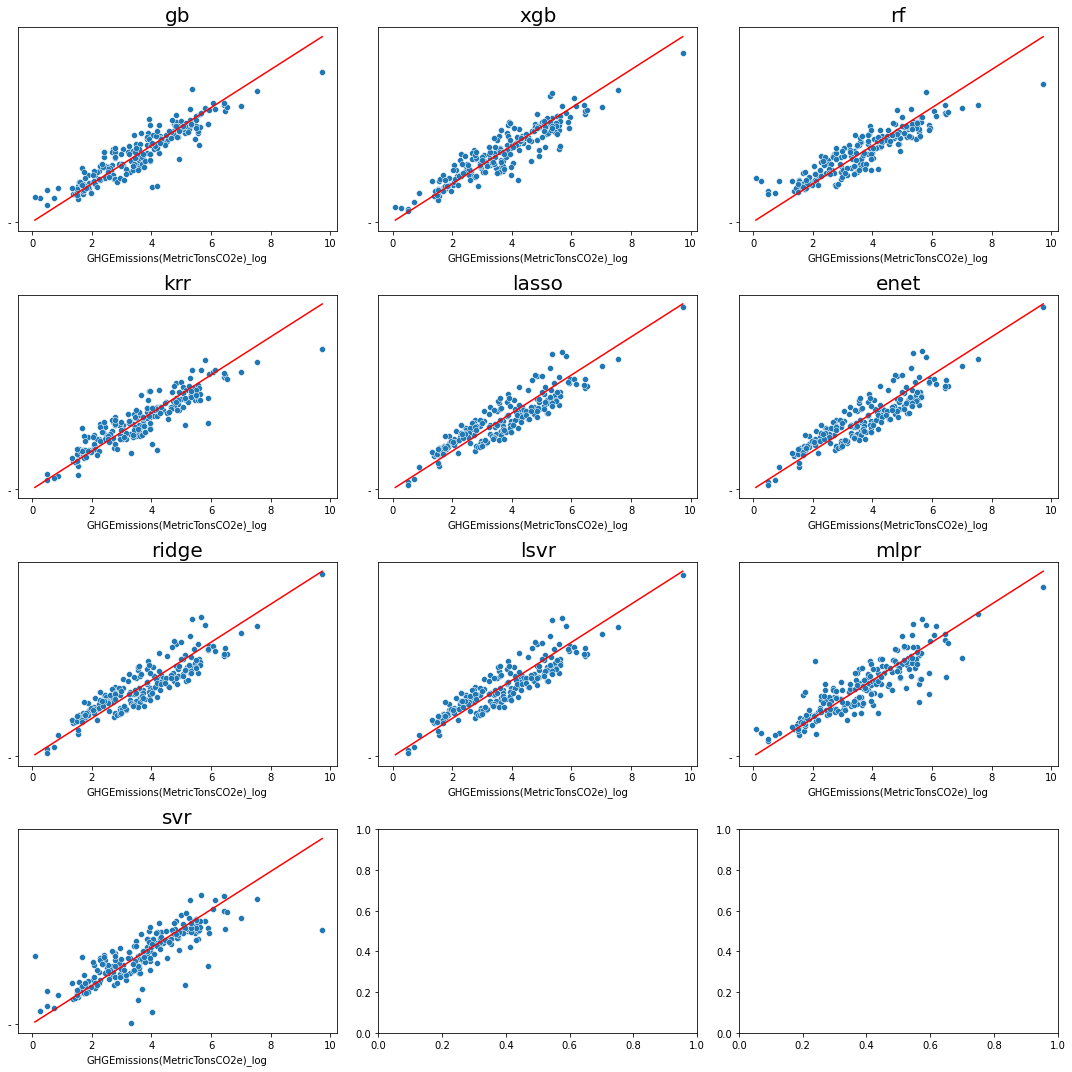

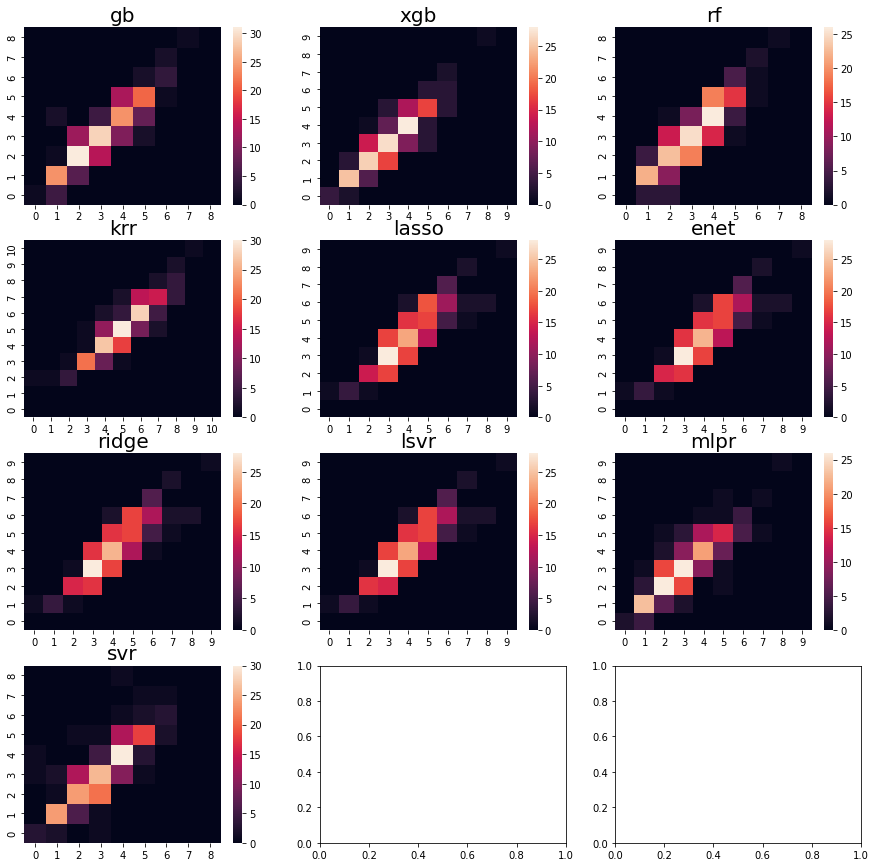

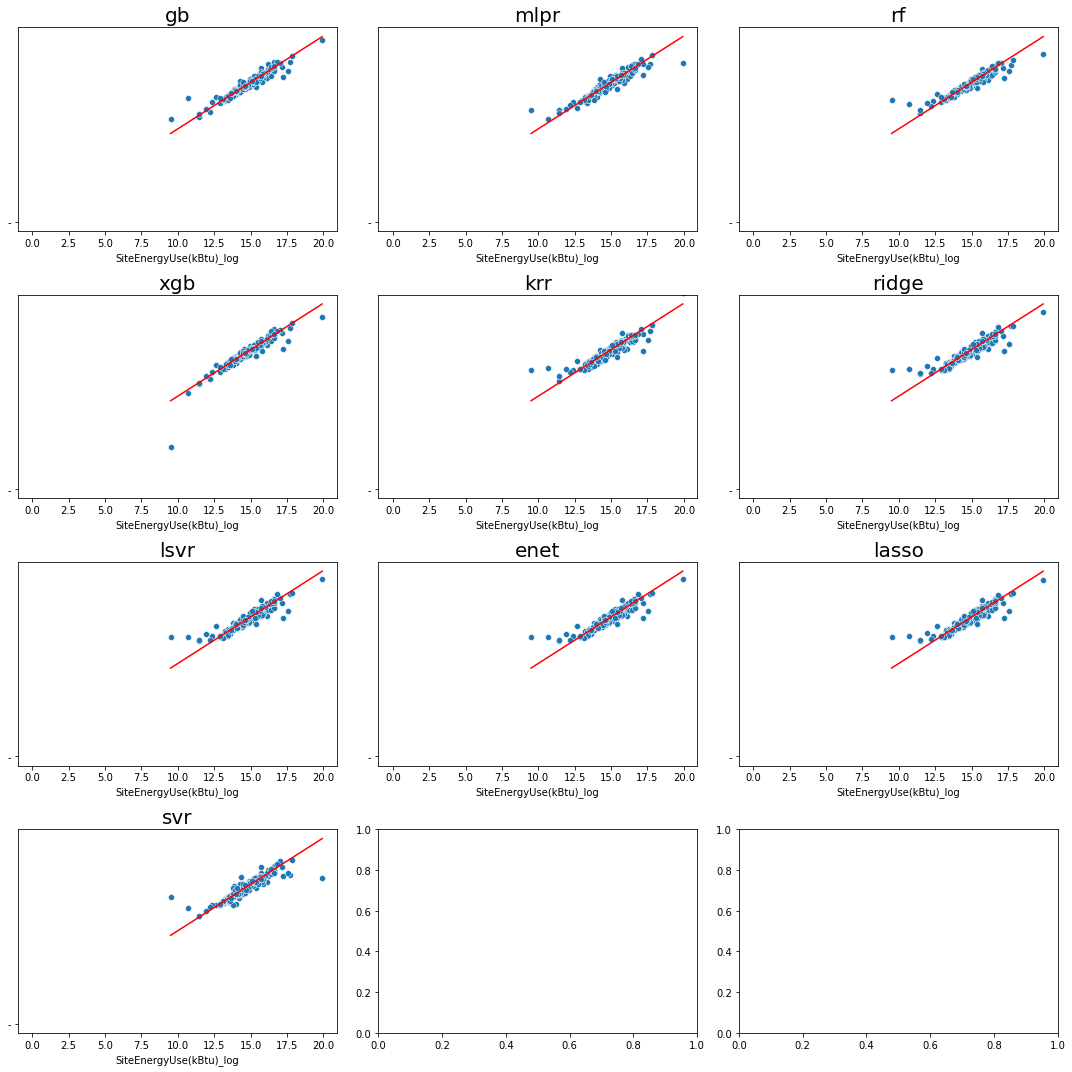

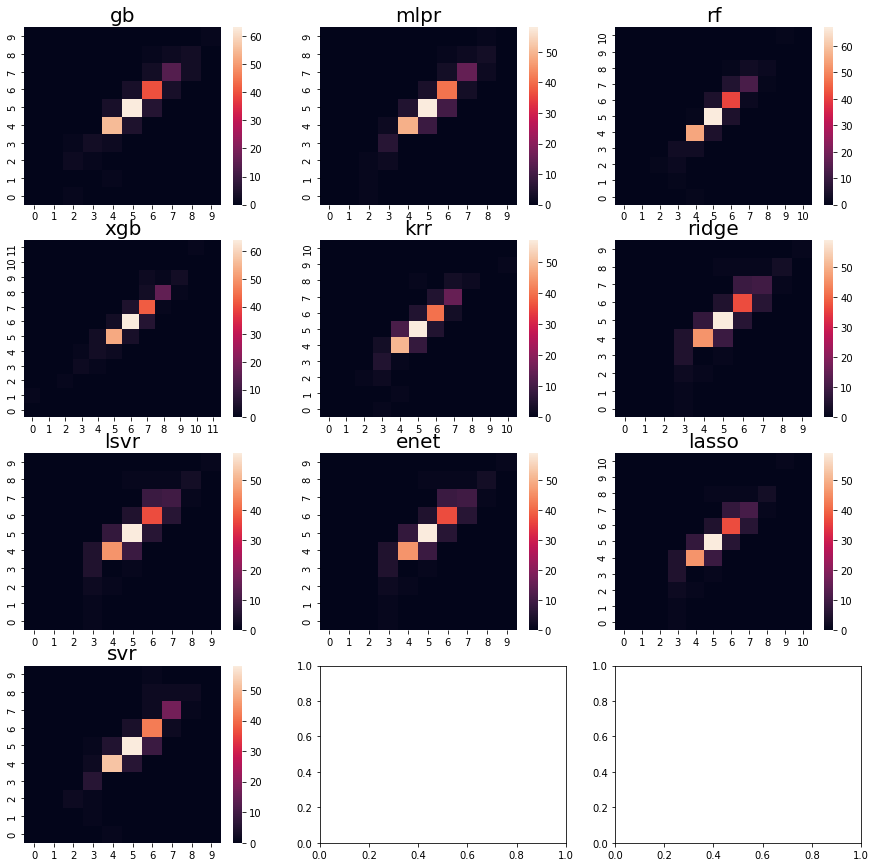

CPU times: user 15.3 s, sys: 1.45 s, total: 16.7 s
Wall time: 15.7 s


In [123]:
%%time
plot_scatter(
    test=df_test[["GHGEmissions(MetricTonsCO2e)_log", "SiteEnergyUse(kBtu)_log"]],
    path="star",
    num_cols=3,
)

**Remarque**<br>
Le modèle Gradient Boosting Regressor est le meilleur pour les 2 targets à prédire, en termes de R2 score, erreur et durée.


## Sans ENERGYSTARScore

In [124]:
# create a list contains the columns to be standard scaled
ss_cols_core = [
    "CouncilDistrictCode",
    "NumberofBuildings",
    "NumberofFloors",
    "Distance",
    "PropertyGFATotal_log",
    "PropertyGFAParking_log",
    "BuiltAge_Ordinal",
    "FirstLargestPropertyUseType_Label",
    "SecondLargestPropertyUseType_Label",
    "ThirdLargestPropertyUseType_Label",
]

In [125]:
# ### import/get the dataframe that is ready for traning models

# # create a list of unnecessry columns
# cols_to_drop = [
#     "OSEBuildingID",
#     "YearBuilt",
#     "PropertyGFATotal",
#     'PropertyGFAParking',
#     "SiteEnergyUse(kBtu)",
#     "GHGEmissions(MetricTonsCO2e)"
# ]

# ### Option 1 - get the df from backup
# df = df_energy.copy()
# df = prepare_df(df, cols_to_drop)
# df.drop(columns='ENERGYSTARScore', inplace=True)
# df_train, df_test = split_train_test(df)


# ### Option 2 - re-import dataframe
# csv_path = 'data/clean_df_model.csv'
# df = pd.read_csv(csv_path)
# df = prepare_df(df, cols_to_drop)
# df.drop(columns='ENERGYSTARScore', inplace=True)
# df_train, df_test = split_train_test(df)

### Option 3 - continue with current dataframe
# remove 'ENERGYSTARScore'
df = df[df.ENERGYSTARScore.notnull()]
df.drop(columns='ENERGYSTARScore', inplace=True)
df_train.drop(columns='ENERGYSTARScore', inplace=True)
df_test.drop(columns='ENERGYSTARScore', inplace=True)

# # backup
df_no_energy = df.copy()
df_train_nostar = df_train.copy()
df_test_nostar = df_test.copy()
print(df_train.shape)
print(df_test.shape)

(4874, 36)
(219, 36)


In [126]:
%%time
# create empty dictionaries to store results
results_nostar = {}
fitted_models_nostar = {}
best_params_nostar = {}
preds_nostar = {}

# iterate through the 2 targets to predict
for index, value in enumerate(target_list):
    # set target variable accordingly
    target = value
    # append the standard scalar columns list accordingly
    if index == 0:
        ss_cols_list = ss_cols_core + [target_list[1]]
    else:
        ss_cols_list = ss_cols_core + [target_list[0]]

    # initialize CompareModels object
    comparemodels = CompareModels(target)
    (
        results_nostar[target],
        fitted_models_nostar[target],
        best_params_nostar[target],
        preds_nostar[target],
    ) = comparemodels.comparemodels(df_train, df_test, ss_cols_list, path="nostar")

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Finished fitting lasso. Used 1.0631389999999783 s 

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Finished fitting ridge. Used 1.38006699999994 s 

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Finished fitting enet. Used 3.46387100000004 s 

Fitting 5 folds for each of 180 candidates, totalling 900 fits
Finished fitting krr. Used 113.00713900000005 s 

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Finished fitting lsvr. Used 1.4841020000001208 s 

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Finished fitting rf. Used 6.39688799999999 s 

Fitting 5 folds for each of 90 candidates, totalling 450 fits
Finished fitting gb. Used 12.904749999999922 s 

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Finished fitting mlpr. Used 952.0300200000001 s 

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Finished fitting svr. Used 5.2838100000001305 s 



Fitting 5 folds for each of 4 candidates, totalling 20 fits
Finished fitting lasso. Used 1.5102540000002591 s 

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Finished fitting ridge. Used 1.1972959999998238 s 

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Finished fitting enet. Used 3.749604999999974 s 

Fitting 5 folds for each of 180 candidates, totalling 900 fits
Finished fitting krr. Used 53.74650200000042 s 

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Finished fitting lsvr. Used 8.691861000000245 s 

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Finished fitting rf. Used 6.014512000000195 s 

Fitting 5 folds for each of 90 candidates, totalling 450 fits
Finished fitting gb. Used 13.450964999999997 s 

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Finished fitting mlpr. Used 284.0563669999997 s 

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Finished fitting svr. Used 4.526992999999948 s 


In [127]:
# save all the results
with open('model/results_all_nostar.pkl', 'wb') as f:
    pickle.dump(results_nostar, f, pickle.HIGHEST_PROTOCOL)
with open('model/fitted_models_all_nostar.pkl', 'wb') as f:
    pickle.dump(fitted_models_nostar, f, pickle.HIGHEST_PROTOCOL)
with open('model/best_params_all_nostar.pkl', 'wb') as f:
    pickle.dump(best_params_nostar, f, pickle.HIGHEST_PROTOCOL)
with open('model/preds_all_nostar.pkl', 'wb') as f:
    pickle.dump(preds_nostar, f, pickle.HIGHEST_PROTOCOL)

In [128]:
# # import results
# with open("model/results_nostar.pkl", "rb") as f:
#     results = pickle.load(f)

# sort results for CO2 emissions
# by ascending MSE, descending R2 and ascedning duration
results_nostar["GHGEmissions(MetricTonsCO2e)_log"].sort_values(
    by=["MSE", "R2 Score", "Duration"], ascending=[True, False, True]
)

,Model,R2 Score,MSE,Duration
6,gb,0.834999,0.376637,0.161934
3,krr,0.831961,0.383572,11.051881
9,xgb,0.825116,0.399196,2864.723230
5,rf,0.822041,0.406217,9.669561
0,lasso,0.799739,0.457124,0.033157
2,enet,0.795243,0.467385,0.020724
1,ridge,0.793245,0.471948,0.024389
4,lsvr,0.792553,0.473527,0.053185
7,mlpr,0.735992,0.602634,26.534389
8,svr,0.654423,0.788826,6.081540


In [129]:
# sort results for CO2 emissions
# by ascending MSE, descending R2 and ascedning duration
results_nostar["SiteEnergyUse(kBtu)_log"].sort_values(
    by=["MSE", "R2 Score", "Duration"], ascending=[True, False, True]
)

,Model,R2 Score,MSE,Duration
6,gb,0.914806,0.137611,0.177747
7,mlpr,0.883210,0.188647,14.628816
5,rf,0.872318,0.206240,10.747567
9,xgb,0.862278,0.222458,2645.099604
3,krr,0.859528,0.226900,11.836144
1,ridge,0.833483,0.268970,0.029858
4,lsvr,0.833459,0.269009,0.294513
2,enet,0.833311,0.269248,0.026234
0,lasso,0.831498,0.272176,0.038255
8,svr,0.816361,0.296626,14.023400


In [9]:
with open('model/best_params_all_nostar.pkl', 'rb') as f:
    best_params_nostar = pickle.load(f)

In [10]:
best_params_nostar["GHGEmissions(MetricTonsCO2e)_log"]['gb']

{'gradientboostingregressor__learning_rate': 0.3,
 'gradientboostingregressor__max_depth': 5,
 'gradientboostingregressor__n_estimators': 700}

In [11]:
best_params_nostar["SiteEnergyUse(kBtu)_log"]['gb']

{'gradientboostingregressor__learning_rate': 0.2,
 'gradientboostingregressor__max_depth': 5,
 'gradientboostingregressor__n_estimators': 700}

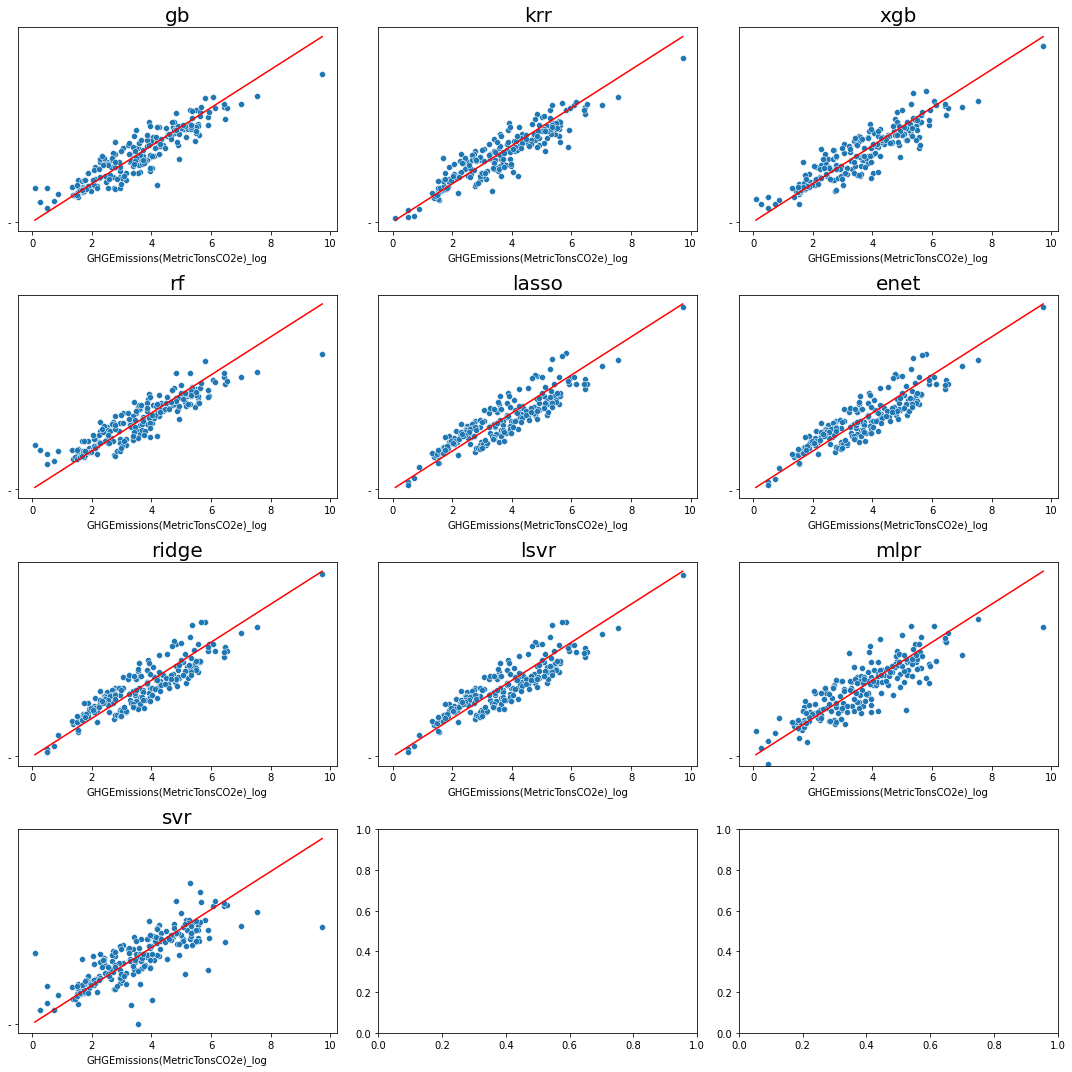

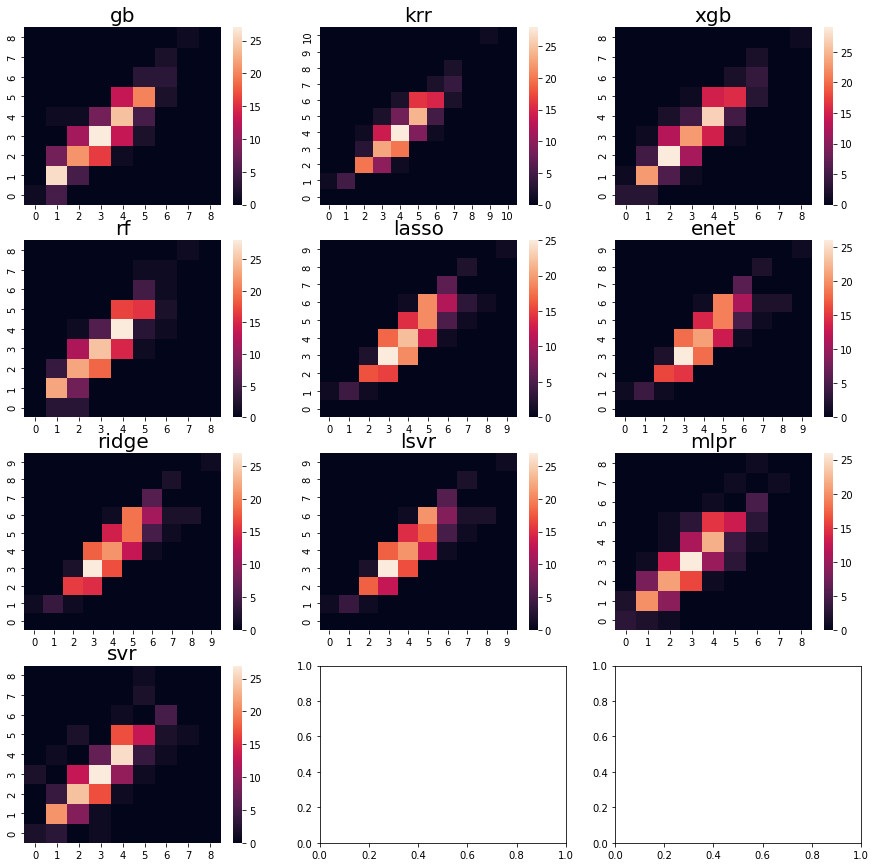

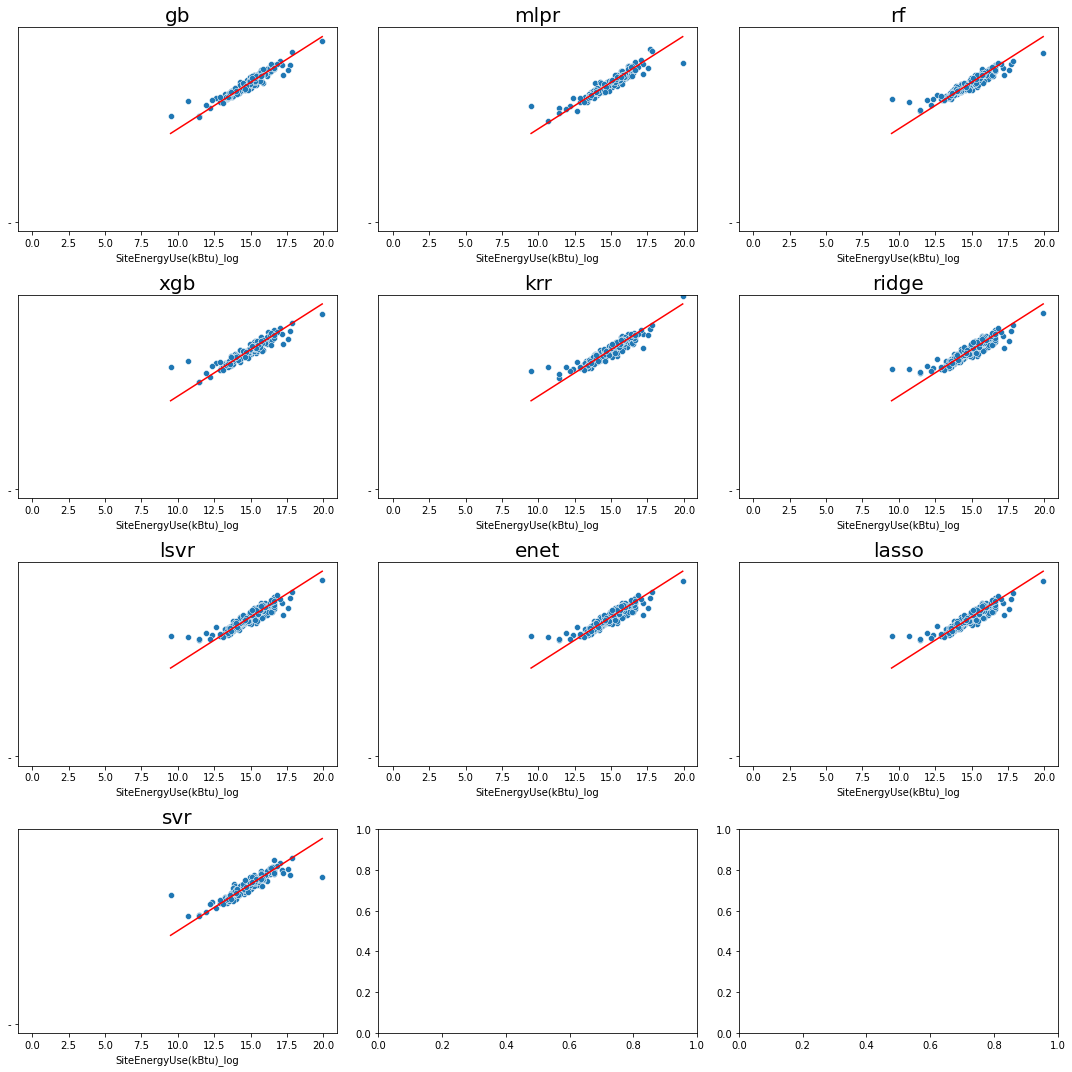

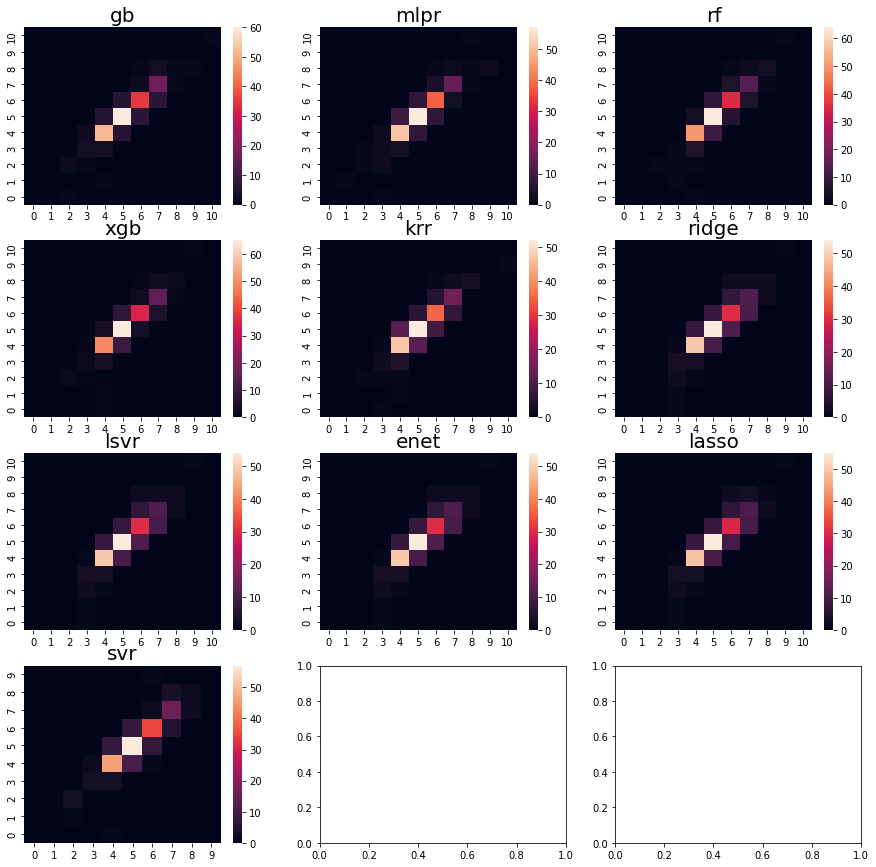

CPU times: user 15.8 s, sys: 1.53 s, total: 17.4 s
Wall time: 17.1 s


In [134]:
%%time
ç(
    test=df_test[["GHGEmissions(MetricTonsCO2e)_log", "SiteEnergyUse(kBtu)_log"]],
    path="nostar",
)

**Remarque**<br>
Pareille pour les données sans ENERGYSTARScore, le modèle Gradient Boosting Regressor est le meilleur pour les 2 targets à prédire, en termes de R2 score, erreur et durée.

# Comparaison

In [90]:
with open("model/results_all_star.pkl", 'rb') as f:
    results_star = pickle.load(f)
with open("model/results_all_nostar.pkl", 'rb') as f:
    results_nostar = pickle.load(f)

In [91]:
# create dataframes for comparison
compare = {}
for target in target_list:
    # get corresponding baseline model result
    baseline = results_dummy_mean[results_dummy_mean.target == target].reset_index(
        drop=True
    )
    baseline["target"] = pd.Series(["baseline"] * 2)
    baseline.rename(columns={"target": "Model"}, inplace=True)
    baseline.insert(loc=1, column="ENERGYSTAR", value="n/a")

    # get corresponding results for models that were trained with ENERGYSTARScore
    result_star = results_star[target].sort_values(
        by=["MSE", "R2 Score", "Duration"], ascending=[True, False, True]
    )[:2]
    result_star.insert(loc=1, column="ENERGYSTAR", value=["score"] * 2)

    # get corresponding results for models that were trained without ENERGYSTARScore
    result_nostar = results_nostar[target].sort_values(
        by=["MSE", "R2 Score", "Duration"], ascending=[True, False, True]
    )[:2]
    result_nostar.insert(loc=1, column="ENERGYSTAR", value=["no score"] * 2)

    # combine all the results
    df_compare = pd.concat(
        [baseline, result_star, result_nostar], ignore_index=True
    ).fillna(0)
    compare[target] = df_compare.sort_values(
        by=["MSE", "R2 Score", "Duration"], ascending=[True, False, True]
    )

In [92]:
# compare models for "GHGEmissions(MetricTonsCO2e)_log"
compare["GHGEmissions(MetricTonsCO2e)_log"]

,Model,ENERGYSTAR,R2 Score,MSE,Duration
1,gb,score,0.848719,0.345319,0.176885
2,xgb,score,0.848321,0.346229,2631.965563
3,gb,no score,0.834999,0.376637,0.161934
4,krr,no score,0.831961,0.383572,11.051881
0,baseline,n/a,-0.003083,2.289675,0.000000


In [193]:
# create a dataframe to plot graph
compare_co2 = compare["GHGEmissions(MetricTonsCO2e)_log"].copy()
compare_co2["ModelCompare"] = compare_co2["Model"] + ' ' + compare_co2["ENERGYSTAR"]

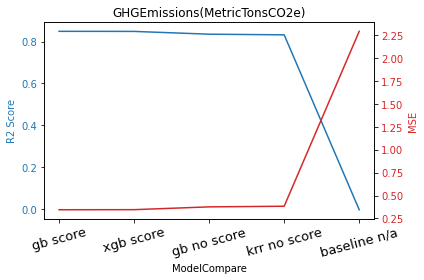

In [222]:
# plot 'R2 Score' and 'MSE' for each model
plot_double_metrics(
    compare_co2,
    x="ModelCompare",
    left="R2 Score",
    right="MSE",
    title="GHGEmissions(MetricTonsCO2e)",
    rotation=15,
)

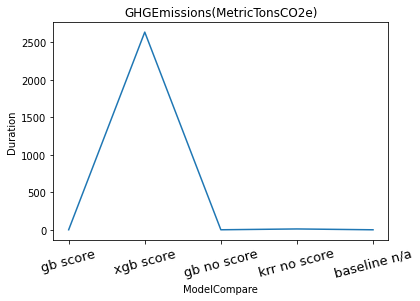

In [223]:
# plot 'duration' for each model
plot_single_metrics(
    compare_co2,
    x="ModelCompare",
    metric="Duration",
    title="GHGEmissions(MetricTonsCO2e)",
    rotation=15,
)

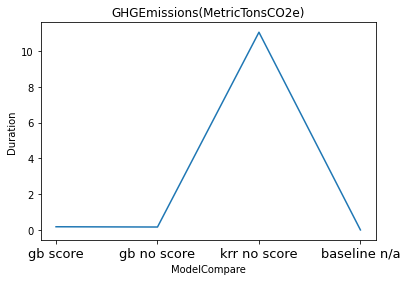

In [228]:
# plot 'duration' for each model, except for xgb (with ENERGYSTARScore)
plot_single_metrics(
    compare_co2.drop(index=2, axis=0),
    x="ModelCompare",
    metric="Duration",
    title="GHGEmissions(MetricTonsCO2e)",
)

In [93]:
# compare models for "SiteEnergyUse(kBtu)_log"
compare["SiteEnergyUse(kBtu)_log"]

,Model,ENERGYSTAR,R2 Score,MSE,Duration
1,gb,score,0.921394,0.126970,0.218575
3,gb,no score,0.914806,0.137611,0.177747
2,mlpr,score,0.900425,0.160840,15.187882
4,mlpr,no score,0.883210,0.188647,14.628816
0,baseline,n/a,-0.002121,1.618695,0.000000


In [216]:
# create a dataframe to plot graph
compare_energy = compare["SiteEnergyUse(kBtu)_log"].copy()
compare_energy["ModelCompare"] = compare_energy["Model"] + ' ' + compare_energy["ENERGYSTAR"]

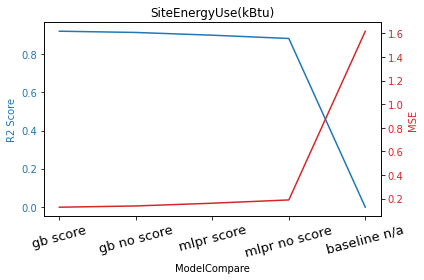

In [225]:
# plot 'R2 Score' and 'MSE' for each model
plot_double_metrics(
    compare_energy,
    x="ModelCompare",
    left="R2 Score",
    right="MSE",
    title="SiteEnergyUse(kBtu)",
    rotation=15,
)

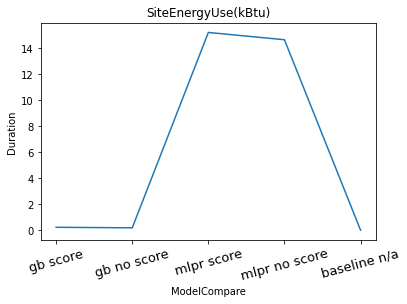

In [226]:
# plot 'duration' for each model
plot_single_metrics(
    compare_energy,
    x="ModelCompare",
    metric="Duration",
    title="SiteEnergyUse(kBtu)",
    rotation=15,
)

**Remarque**<br>
En comparant les modèles qui prédisent les meilleurs, c'est toujours le Gradient Boosting Regressor qui gagne en termes de R2 score, erreur et durée pour les 2 targets à prédire.

# Fin